# Stroke Risk Classification: An End-to-End Data Science Workflow

In this notebook I tackle a binary classification problem from start to finish using a publicly-available stroke dataset. The goal is to demonstrate a systematic approach to solving a real-world classification task rather than a deep dive in the specific nuances of this case.

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from utils import *
from stroke_prediction_model import StrokePredictor

import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### Load Data

In [2]:
data = pd.read_csv('stroke_data.csv')
print('Shape:', data.shape)
data.head()

Shape: (5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Missing Values

In [3]:
missing_df = missing_values(data)
missing_df

,feature,count,percent
0,bmi,201,3.9
1,id,0,0.0
2,gender,0,0.0
3,age,0,0.0
4,hypertension,0,0.0
5,heart_disease,0,0.0
6,ever_married,0,0.0
7,work_type,0,0.0
8,Residence_type,0,0.0
9,avg_glucose_level,0,0.0


Only bmi shows missing values. I will impute these values at the preprocessing section.

### Exploratory Data Analysis

- Pie chart of stroke vs. no-stroke

- Histograms by stroke status

- Correlation of numeric features

- Age vs. glucose/bmi vs. stroke

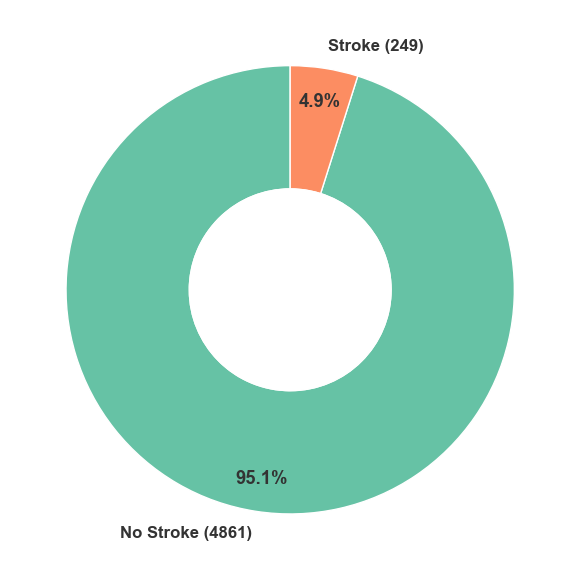

In [4]:
plot_stroke_distribution(data)

This is a very imbalanced dataset, where strokes only account for 5% of the total observations. It would help greatly to gather more data to improve model predictions and interpretability. Given this huge imbalance and given that the dataset is quite small (5110 rows, 249 strokes), I will later need to use SMOTE to oversample the minority class and help the model learn to predict strokes.

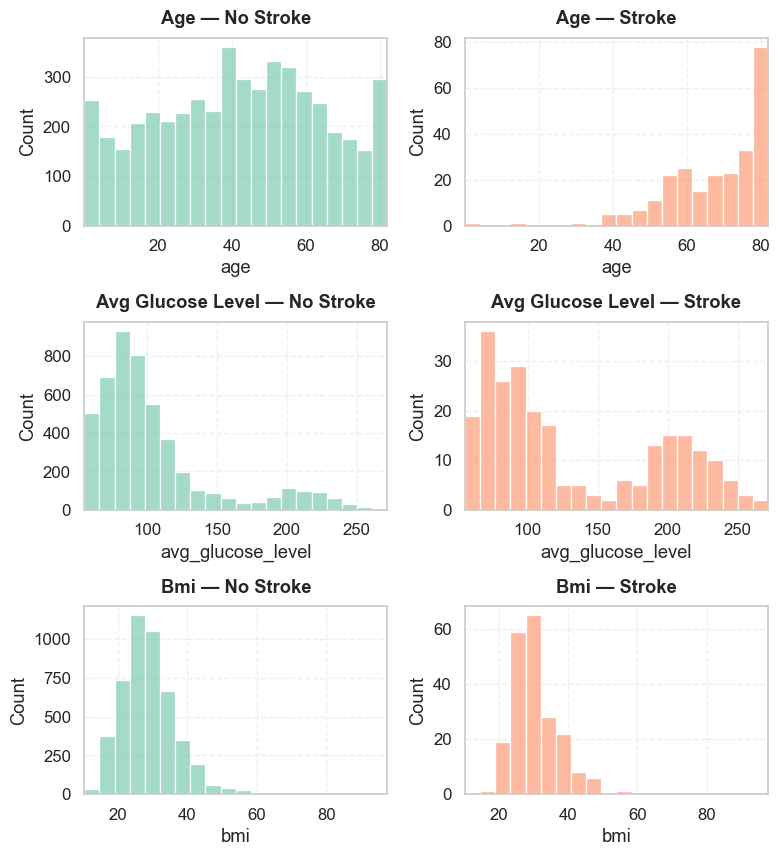

In [5]:
plot_histograms_by_stroke(data)

- Age distribution is very different when comparing stroke cases vs no stroke. This is clearly a signal that age will be a critical feature in the predictions.

- Average glucose level also shows differences, but smaller than the ones we observe for age distributions. Nevetheless, it is clear that greater glucose levels are observed among those that had a stroke.

- Contrary to what I expected, bmi distributions look similar between stroke and no stroke populations. However, tt looks like the left part of the distribution (smaller bmi) is more populated for no stroke cases.

In [6]:
corr_pairs = get_numeric_correlations(data)
corr_pairs

age                bmi                  0.333398
                   avg_glucose_level    0.238171
avg_glucose_level  bmi                  0.175502
dtype: float64

There is no important correlation betweeen numeric features to be bothered about. Age-bmi is the greater one with a coefficient of 0.33.

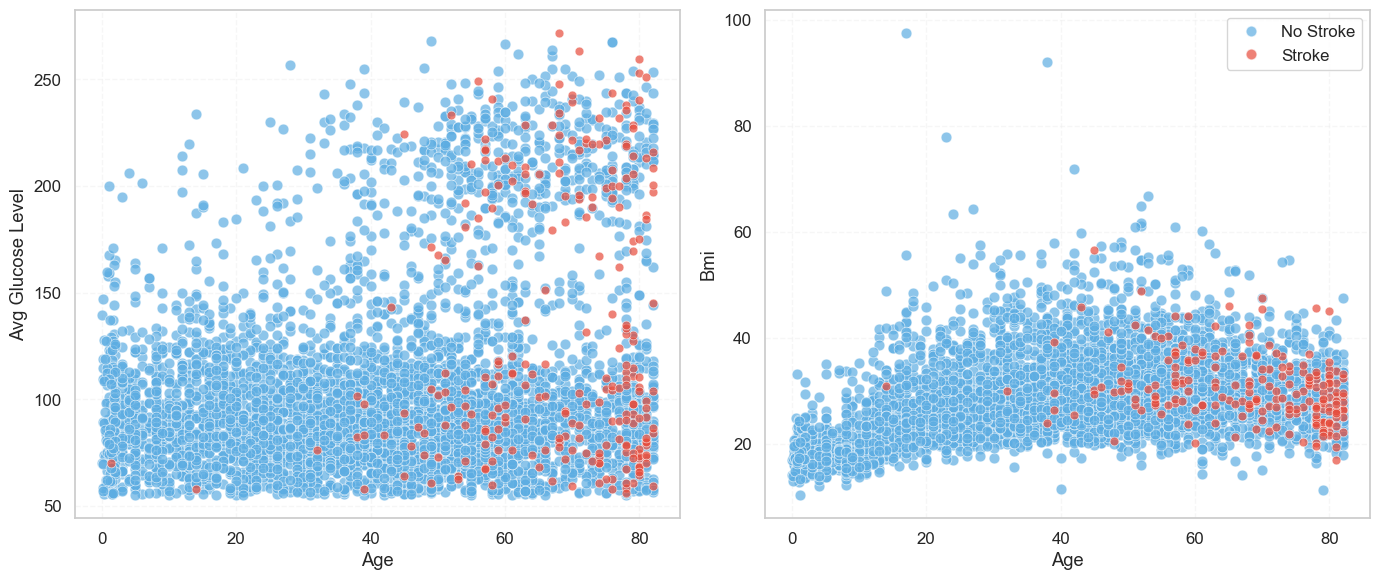

In [7]:
plot_age_vs_glucose_and_BMI(data)

Both these plots reassure the previous observations. Age is a critical factor for stroke prediction. Additionaly, we can see how points with high glucose levels show much more stroke cases.

### Preprocessing

- Predictive imputation of BMI with age and gender.

- Drop unnecessary columns and one-hot encoding of categorical variables.

In [8]:
predictor = StrokePredictor(random_state=42)
X, y = predictor.preprocess(data)
X.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Male,gender_Other,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,True,False,True,False,True,False,False,True,True,False,False
1,61.0,0,0,202.21,29.879487,False,False,True,False,False,True,False,False,False,True,False
2,80.0,0,1,105.92,32.500000,True,False,True,False,True,False,False,False,False,True,False
3,49.0,0,0,171.23,34.400000,False,False,True,False,True,False,False,True,False,False,True
4,79.0,1,0,174.12,24.000000,False,False,True,False,False,True,False,False,False,True,False


### Model Training & First Comparison

- Train/test split.

- SMOTE oversampling on training set.

- Compare Logistic Regression and Random Forest via cross-validation.

In [9]:
X_train, X_test, y_train, y_test = predictor.split_data(X, y)
X_train_res, y_train_res = predictor.oversample(X_train, y_train)

In [10]:
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', predictor.scaler),
        ('lr', LogisticRegression(max_iter=1000, random_state=predictor.random_state))
    ]),
    'RandomForest': Pipeline([
        ('scaler', predictor.scaler),
        ('rf', RandomForestClassifier(n_estimators=100, random_state=predictor.random_state))
    ]),
}

In [11]:
results = predictor.pipelines_cross_validation(X_train_res, y_train_res, pipelines=pipelines, cv=10)

LogisticRegression CV — Acc: 0.873, Prec: 0.865, Rec: 0.884, F1: 0.873
RandomForest CV — Acc: 0.960, Prec: 0.957, Rec: 0.962, F1: 0.957


Random Forest model seems better than Logistic Regression in every single metric. Let's check the results for test data.

### Evaluate on Test Data

In [12]:
pipelines = predictor.fit_pipelines_train(X_train_res, y_train_res, pipelines=pipelines)
for name, pipe in pipelines.items():
    print(f"Evaluation results for {name}:")
    preds = predictor.evaluate_pipelines_test(pipe)
    print('')

Evaluation results for LogisticRegression:
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.97      0.87      0.91       972
           1       0.15      0.46      0.23        50

    accuracy                           0.85      1022
   macro avg       0.56      0.66      0.57      1022
weighted avg       0.93      0.85      0.88      1022


Evaluation results for RandomForest:
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.19      0.18      0.18        50

    accuracy                           0.92      1022
   macro avg       0.57      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022




F1 scores drop dramatically since the test data is not SMOTE'd. That is expected behaviour. It's interesting that in the test data, Random Forest shows better Accuracy and Precision but worse F1 Score and Recall compared to Logistic Regression. It looks like Random Forest may have overfitted the noise coming from the SMOTE generated data.

False negatives are more costly when dealing with medical diagnosis or medical predictions. Hence, in my opinion, Logistic Regression is here the better model. However, before jumping into this conclusion, let's optimize the models' hyperparameters with a focus on Recall and see which one performs better.

### Hyperparameters Optimization

Now, regular non-SMOTE'd data will be used for optimization and SMOTE will be included as part of the model pipeline. This way I will obtain metrics comparable to the ones obtained with the test set data.

In [13]:
pipeline = Pipeline([
    ('smote', predictor.smote),
    ('scaler', predictor.scaler),
    ('rf', RandomForestClassifier(random_state=predictor.random_state))
])
best_rf = predictor.optimize_random_forest(scoring='recall', pipeline=pipeline)

pipeline = Pipeline([
    ('smote', predictor.smote),
    ('scaler', predictor.scaler),
    ('lr', LogisticRegression(max_iter=1000, random_state=predictor.random_state))
])
best_lr = predictor.optimize_logistic_regression(scoring='recall', pipeline=pipeline)

Random Forest - Best Params: {'rf__bootstrap': True, 'rf__max_features': 5, 'rf__n_estimators': 100}
Random Forest - Best CV recall: 0.146
Logistic Regression - Best Params: {'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Logistic Regression - Best CV recall: 0.498


In [14]:
print('Evaluation results for recall-optimized RandomForest')
preds = predictor.evaluate_pipelines_test(best_rf)
print('')
print('Evaluation results for recall-optimized LogisticRegression')
preds = predictor.evaluate_pipelines_test(best_lr)

Evaluation results for recall-optimized RandomForest
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.19      0.20      0.20        50

    accuracy                           0.92      1022
   macro avg       0.58      0.58      0.58      1022
weighted avg       0.92      0.92      0.92      1022


Evaluation results for recall-optimized LogisticRegression
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.15      0.60      0.25        50

    accuracy                           0.82      1022
   macro avg       0.57      0.72      0.57      1022
weighted avg       0.94      0.82      0.87      1022



Logistic Regression gets a much better Recall than Random Forest. It does have less accuracy but overall better F1 score. Let's see how changing the threshold impacts these metrics.

### Threshold implications

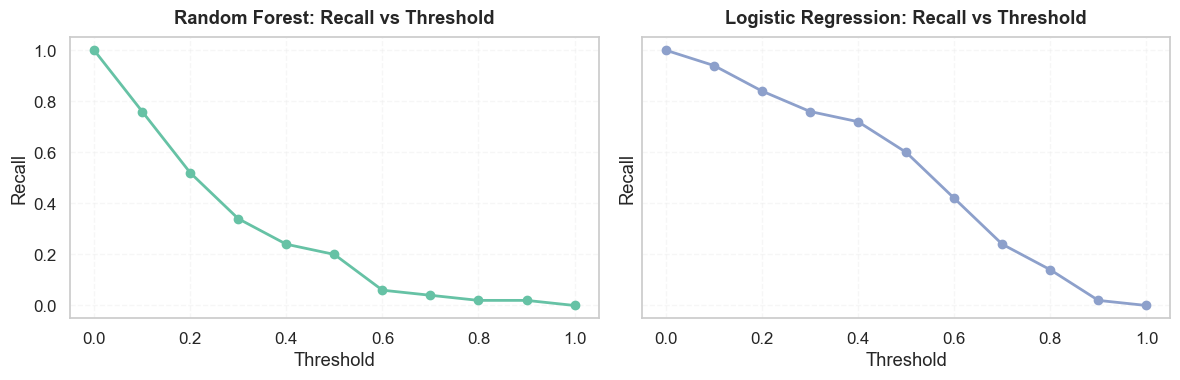

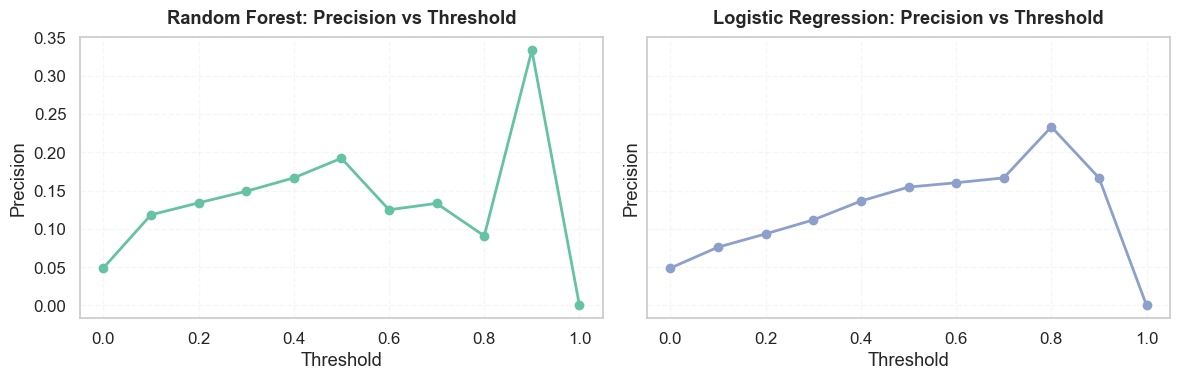

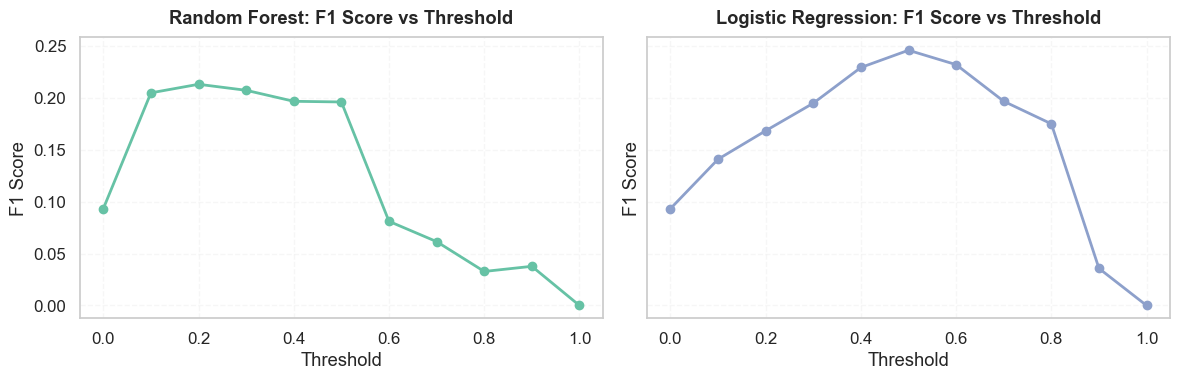

In [15]:
plot_metric_comparison(best_rf, best_lr, X_test, y_test, metric='recall', step=0.1)
plot_metric_comparison(best_rf, best_lr, X_test, y_test, metric='precision', step=0.1)
plot_metric_comparison(best_rf, best_lr, X_test, y_test, metric='f1', step=0.1)

It looks like using threshold 0.4 would give us quite an important boost in Recall for Logistic Regression at the expense of little F1 score. Hence, 0.4 looks the way to go to me.

### Selected Model

In [16]:
print("Selected Model:")
preds = predictor.evaluate_pipelines_test(best_lr, threshold=0.4)

Selected Model:
(threshold=0.4):
              precision    recall  f1-score   support

           0       0.98      0.77      0.86       972
           1       0.14      0.72      0.23        50

    accuracy                           0.76      1022
   macro avg       0.56      0.74      0.54      1022
weighted avg       0.94      0.76      0.83      1022



### What if we optimized for F1-Score?

For completeness, it would be interesting to also obtain the best model in terms of F1 score. Let's optimize the models' hyperparameters with a focus on F1 score and see which one performs better.

In [17]:
pipeline = Pipeline([
    ('smote', predictor.smote),
    ('scaler', predictor.scaler),
    ('rf', RandomForestClassifier(random_state=predictor.random_state))
])
best_rf = predictor.optimize_random_forest(scoring='f1', pipeline=pipeline)

pipeline = Pipeline([
    ('smote', predictor.smote),
    ('scaler', predictor.scaler),
    ('lr', LogisticRegression(max_iter=1000, random_state=predictor.random_state))
])
best_lr = predictor.optimize_logistic_regression(scoring='f1', pipeline=pipeline)

Random Forest - Best Params: {'rf__bootstrap': True, 'rf__max_features': 5, 'rf__n_estimators': 64}
Random Forest - Best CV f1: 0.151
Logistic Regression - Best Params: {'lr__C': 0.01, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}
Logistic Regression - Best CV f1: 0.209


Interesting to see that F1-optimization and Recall-optimization lead to the same parameters for Logistic Regression.

In [18]:
print('Evaluation results for F1-optimized RandomForest')
preds = predictor.evaluate_pipelines_test(best_rf)
print('')
print('Evaluation results for F1-optimized LogisticRegression')
preds = predictor.evaluate_pipelines_test(best_lr)

Evaluation results for F1-optimized RandomForest
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       972
           1       0.17      0.18      0.17        50

    accuracy                           0.92      1022
   macro avg       0.56      0.57      0.57      1022
weighted avg       0.92      0.92      0.92      1022


Evaluation results for F1-optimized LogisticRegression
(threshold=0.5):
              precision    recall  f1-score   support

           0       0.98      0.83      0.90       972
           1       0.15      0.60      0.25        50

    accuracy                           0.82      1022
   macro avg       0.57      0.72      0.57      1022
weighted avg       0.94      0.82      0.87      1022



After hyperparameter optimization, the best model in terms of F1 score is Logistic Regression. However, Random Forest mantains the lead in Accuracy. Let's see how changing the threshold might impact F1 score.

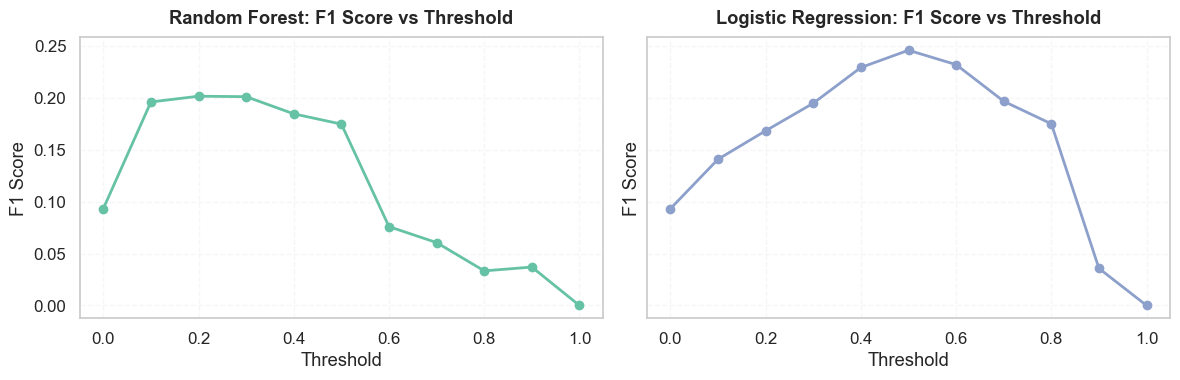

In [19]:
plot_metric_comparison(best_rf, best_lr, X_test, y_test, metric='f1', step=0.1)

Maximum F1 score value corresponds to the optimized Logistic Regression with the default 0.5 threshold.

### ROC and PR curves

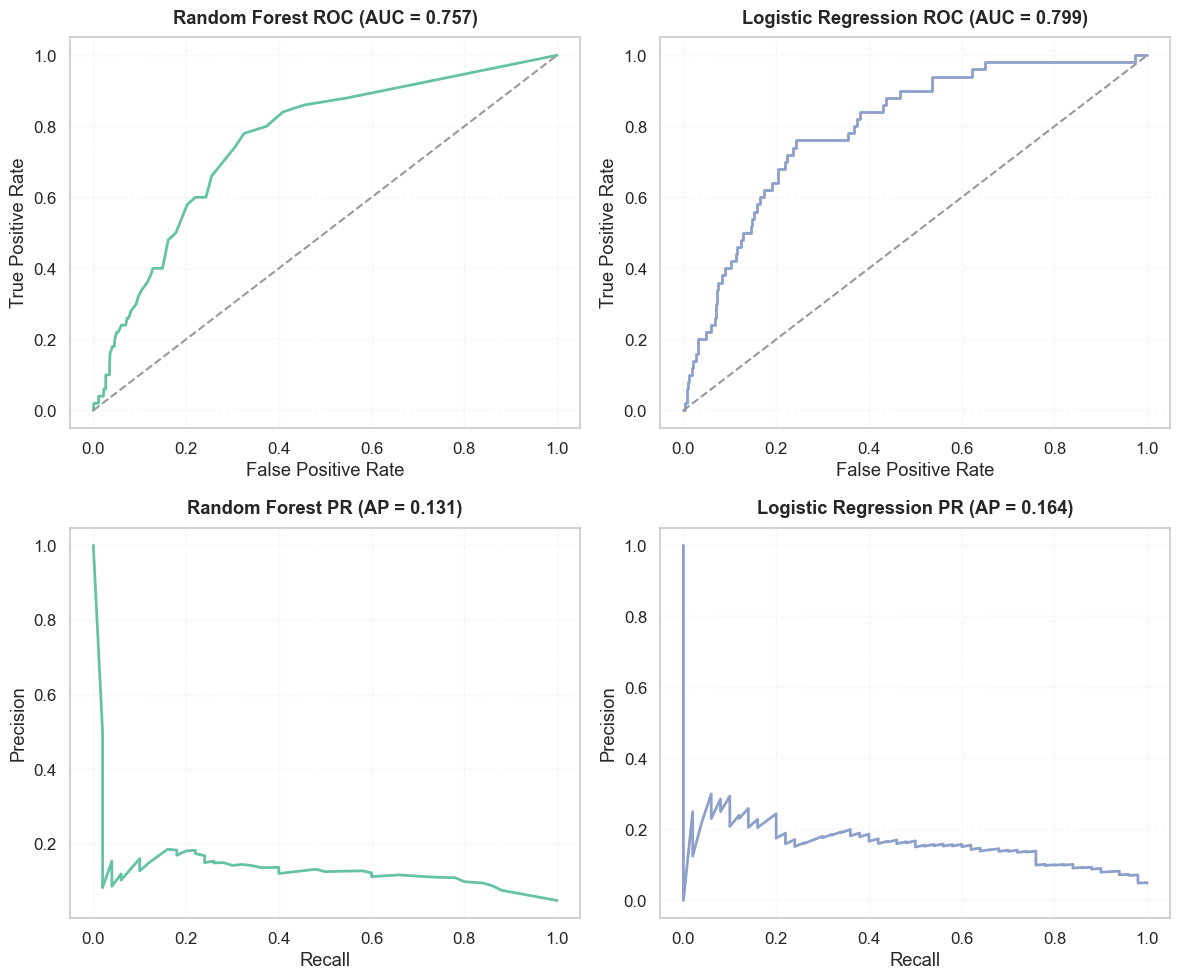

In [20]:
plot_model_threshold_curves(best_rf, best_lr, X_test, y_test)

Logistic Regressions shows better ROC AUC and better PR AP, signaling both better ability to discriminate between the positive and negative class while also performing better on the positive class alone.

### Feature Importances

Here, I use the features importances of the random forest model to understand which features were more important in its predictions.

In [21]:
fi = pd.DataFrame({'Feature':X_train.columns, 'Importance':best_rf.named_steps['rf'].feature_importances_}).sort_values('Importance', ascending=False)
print('Random Forest feature importances:')
fi[:10].style.background_gradient()

Random Forest feature importances:


,Feature,Importance
0,age,0.340378
3,avg_glucose_level,0.140796
4,bmi,0.103594
7,ever_married_Yes,0.077654
13,smoking_status_formerly smoked,0.057202
9,work_type_Private,0.046799
10,work_type_Self-employed,0.046777
5,gender_Male,0.044705
14,smoking_status_never smoked,0.039643
12,Residence_type_Urban,0.038592


As expected from EDA, Random Forest, shows age as the most important feature followed by avg_glucose level. Bmi appears in third place.

### Conclusions

- This is very imbalanced dataset, where there are only 249 positive class examples. Gathering more data would help greatly to improve model predictions and interpretability.

- In EDA, age was reavealed as the most critical factor for stroke prediction. More age -> more risk. Average glucose level was also identified as important.

- Random forest and logistic regression models were evaluated. Random forest showed better accuracy while logistic regression had better f1-score and recall.

- Therefore, I selected logistic regression as the best model, which may be used with a threshold of 0.4 for optimal recall score.

- Random forest feature importances showed how age, glucose level, and bmi were the most important factors for accurate stroke prediction.